In [47]:
import pandas as pd
import numpy as np
#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm
import time
from time import sleep

def get_distance_from_paydays(date):
    end_of_month = date.daysinmonth
    distance_to_1st = 0 if date.day >=15 else 15 - date.day
    distance_to15th = 0 if date.day < 15 else end_of_month - date.day
    return distance_to_1st + distance_to15th

def std(x): return np.std(x)

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            if str(col_type) == numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            if str(col_type)[:5] == 'float':
                c_min = df[col].min()
                c_max = df[col].max()

                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## Simple "Memory profilers" to see memory usage
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2) 
        
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)


In [48]:
if True:
    df_train = pd.read_csv('../../dataset/train/train_converted.csv')
    df_test  = pd.read_csv('../../dataset/test/test_converted.csv')
    df_train = df_train[['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK','Z_WEEK_DATE','Demanda']].groupby(['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK','Z_WEEK_DATE']).sum().reset_index()
    df_test = df_test[['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK','Z_WEEK_DATE','Demanda']].groupby(['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK','Z_WEEK_DATE']).sum().reset_index()

else:

    df_train = pd.read_pickle('../../dataset/train/train_converted_fill.pkl')
    df_test  = pd.read_pickle('../../dataset/test/test_converted_fill.pkl')

df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)


df_train.replace(['',np.inf, -np.inf, np.nan],0,inplace=True)
df_test.replace(['',np.inf, -np.inf, np.nan],0,inplace=True)

Memory usage of dataframe is 107.97 MB
Memory usage after optimization is: 33.78 MB
Decreased by 68.7%
Memory usage of dataframe is 21.59 MB
Memory usage after optimization is: 4.08 MB
Decreased by 81.1%


In [49]:
for column in ['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK']:
    df_train[column] = df_train[column].astype(str)
    df_test[column] = df_test[column].astype(str)

In [50]:
df_train['ID'] = df_train['Z_MODELO'] + '|' + df_train['Z_PUNTO_VENTA'] + '|' + df_train['Z_GAMA']
df_test['ID'] = df_test['Z_MODELO'] + '|' + df_test['Z_PUNTO_VENTA'] + '|' + df_test['Z_GAMA']

base = df_train[['ID', 'Demanda', 'Z_WEEK_DATE']].groupby(['ID', 'Z_WEEK_DATE']).sum().sort_values('Demanda' , ascending = [False]).reset_index()
base_cum = df_train[['Demanda', 'Z_WEEK_DATE']].groupby([ 'Z_WEEK_DATE']).sum().sort_values('Demanda' , ascending = [False]).reset_index()

In [51]:
df_train.head(1)

,Z_MODELO,Z_PUNTO_VENTA,Z_GAMA,Z_WEEK,Z_WEEK_DATE,Demanda,ID
0,MOD_1,PVENT_1,GAM_1,SEMANA_01,2021-05-17,0,MOD_1|PVENT_1|GAM_1


In [52]:
base = base.merge(base_cum[['Z_WEEK_DATE', 'Demanda']].rename(columns = {'Demanda': 'Demanda_Total'}), on = 'Z_WEEK_DATE', how = "left")

In [53]:
base

,ID,Z_WEEK_DATE,Demanda,Demanda_Total
0,MOD_3|PVENT_1|GAM_4,2021-07-19,1451,45037
1,MOD_3|PVENT_1|GAM_4,2021-07-12,1201,47069
2,MOD_27|PVENT_1|GAM_1,2021-06-07,1032,38374
3,MOD_3|PVENT_1|GAM_4,2021-06-21,1005,40481
4,MOD_2|PVENT_1|GAM_1,2021-12-06,934,43389
...,...,...,...,...
2358645,MOD_25|PVENT_409|GAM_1,2022-02-21,0,32408
2358646,MOD_25|PVENT_409|GAM_1,2022-02-14,0,33511
2358647,MOD_25|PVENT_409|GAM_1,2022-02-07,0,35144
2358648,MOD_25|PVENT_409|GAM_1,2022-01-31,0,32240


In [54]:
base['ratio'] = base['Demanda']*100/base['Demanda_Total']

In [55]:
base

,ID,Z_WEEK_DATE,Demanda,Demanda_Total,ratio
0,MOD_3|PVENT_1|GAM_4,2021-07-19,1451,45037,3.221795
1,MOD_3|PVENT_1|GAM_4,2021-07-12,1201,47069,2.551573
2,MOD_27|PVENT_1|GAM_1,2021-06-07,1032,38374,2.689321
3,MOD_3|PVENT_1|GAM_4,2021-06-21,1005,40481,2.482646
4,MOD_2|PVENT_1|GAM_1,2021-12-06,934,43389,2.152619
...,...,...,...,...,...
2358645,MOD_25|PVENT_409|GAM_1,2022-02-21,0,32408,0.000000
2358646,MOD_25|PVENT_409|GAM_1,2022-02-14,0,33511,0.000000
2358647,MOD_25|PVENT_409|GAM_1,2022-02-07,0,35144,0.000000
2358648,MOD_25|PVENT_409|GAM_1,2022-01-31,0,32240,0.000000


In [56]:
df_train = df_train.merge(base[['ID','Z_WEEK_DATE','ratio']],how='left') # ,'Demanda_Total'

In [57]:
df_test  = df_test.merge(base[['ID','Z_WEEK_DATE','ratio']],how='left') # ,'Demanda_Total'

In [58]:
df_train.head(1)

,Z_MODELO,Z_PUNTO_VENTA,Z_GAMA,Z_WEEK,Z_WEEK_DATE,Demanda,ID,ratio
0,MOD_1,PVENT_1,GAM_1,SEMANA_01,2021-05-17,0,MOD_1|PVENT_1|GAM_1,0.0


In [59]:
df_train.drop(columns = ['ID','Demanda'],inplace=True)
df_test.drop(columns = ['ID','Demanda'],inplace=True)

In [60]:
TARGET = 'ratio'

In [61]:
print('Creating date_block_num ...')
N_submission = df_test.shape[0]
N_sales      = df_train.shape[0]

print(df_train.shape,df_test.shape)

dates = (set(df_train['Z_WEEK'].unique()) | set(df_test['Z_WEEK'].unique()))#df_auxiliar['Z_WEEK'].unique()
dates = sorted(dates)

dict_dates = {}
for idx,date in enumerate(dates):
    dict_dates[date] =idx
    
    
df_train['date_block_num'] = df_train['Z_WEEK'].map(dict_dates)
df_test['date_block_num'] = df_test['Z_WEEK'].map(dict_dates)

df_train.replace(['',np.inf, -np.inf, np.nan],0,inplace=True)
df_test.replace(['',np.inf, -np.inf, np.nan],0,inplace=True)

print('Creating date_block_num completed!')


print('Preprocessing TRAINING DATASET ...')


df_train['Z_WEEK_DATE'] = pd.to_datetime(df_train['Z_WEEK_DATE'])
df_train['days_from_payday'] = df_train['Z_WEEK_DATE'].apply(get_distance_from_paydays)


statistics_columns = [ ]

df_train["log_ratio"] = np.log(df_train['ratio'] + 1e-8)
#df_test["log_Demanda"] = np.log(1e-8)

statistics_columns.append('log_ratio')

#'''
bar1 = tqdm([
    ['Z_MODELO'],
    ['Z_PUNTO_VENTA'],
    ['Z_GAMA'],
    ['Z_MODELO','Z_PUNTO_VENTA'],
    ['Z_MODELO','Z_GAMA'],
    ['Z_PUNTO_VENTA','Z_GAMA'],
    ['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA']], position=0, desc="i",colour='green', ncols=80)
time.sleep(1)

bar2 = tqdm(['mean'], position=1, desc="j", colour='red', ncols=80, leave=False) #'std','max','min','sum'
time.sleep(1)

unique_columns = [ ]
        
for column_names in bar1:
    bar1.update()
    bar2.refresh()  #force print final state
    time.sleep(0.1)
    bar2.reset()  #reuse bar
    for statistic in bar2:
        
        new_column_name = statistic+'_sales_by_'+'_'.join(column_names)
        #df_train[new_column_name] = df_train.groupby(["Z_WEEK_DATE"]+column_names, observed=True).Demanda.transform(statistic)
        if statistic == 'mean':
            df_agg = df_train.groupby(["Z_WEEK"]+column_names, observed=True).ratio.mean()
        if statistic == 'std':
            df_agg = df_train.groupby(["Z_WEEK"]+column_names, observed=True).ratio.std(ddof=0)
        if statistic == 'max':
            df_agg = df_train.groupby(["Z_WEEK"]+column_names, observed=True).ratio.max()
        if statistic == 'min':
            df_agg = df_train.groupby(["Z_WEEK"]+column_names, observed=True).ratio.min()
        if statistic == 'sum':
            df_agg = df_train.groupby(["Z_WEEK"]+column_names, observed=True).ratio.sum()        
        if df_agg.shape[0] >= df_train.shape[0]*0.7:
            unique_columns.append([["Z_WEEK"]+column_names,new_column_name])
            continue
        
        df_agg = df_agg.reset_index()
        df_agg.columns = df_agg.columns.str.replace('ratio', new_column_name)
        
        df_train = df_train.merge(df_agg,on=["Z_WEEK"]+column_names,how='left')
        statistics_columns.append(new_column_name)
        bar2.update()
        time.sleep(0.05)
#'''
df_train['dayofweek'] = df_train['Z_WEEK_DATE'].dt.dayofweek.astype('str').astype('category')
df_train['month'] = df_train['Z_WEEK_DATE'].dt.month.astype('str').astype('category')
df_train['dayofyear'] = df_train['Z_WEEK_DATE'].dt.dayofyear.astype('str').astype('category')

df_train.drop(columns=['Z_WEEK_DATE'],inplace=True)
df_train.drop(columns=['Z_WEEK'],inplace=True)

print('Preprocessing TRAINING DATASET COMPLETED!')
print('Preprocessing TESTING DATASET ...')


df_test['Z_WEEK_DATE'] = pd.to_datetime(df_test['Z_WEEK_DATE'])
df_test['days_from_payday'] = df_test['Z_WEEK_DATE'].apply(get_distance_from_paydays)

inv_dict_dates = {v: k for k, v in dict_dates.items()}
#df_test['Z_WEEK'] = df_test['date_block_num'].map(inv_dict_dates)
df_test = df_test[['date_block_num','Z_MODELO','Z_PUNTO_VENTA','Z_GAMA',"ratio","Z_WEEK_DATE"]]

df_test['dayofweek'] = df_test['Z_WEEK_DATE'].dt.dayofweek.astype('str').astype('category')
df_test['month'] = df_test['Z_WEEK_DATE'].dt.month.astype('str').astype('category')
df_test['dayofyear'] = df_test['Z_WEEK_DATE'].dt.dayofyear.astype('str').astype('category')



df_test['days_from_payday'] = df_test['Z_WEEK_DATE'].apply(get_distance_from_paydays)
df_test.drop(columns=['Z_WEEK_DATE'],inplace=True)

print('Preprocessing TESTING DATASET COMPLETED!')


Creating date_block_num ...
(2358650, 6) (471730, 6)
Creating date_block_num completed!
Preprocessing TRAINING DATASET ...


i: 100%|██████████████████████████████████████████| 7/7 [00:09<00:00,  1.39s/it]


Preprocessing TRAINING DATASET COMPLETED!
Preprocessing TESTING DATASET ...
Preprocessing TESTING DATASET COMPLETED!


In [62]:
df_train = reduce_mem_usage(df_train)

Memory usage of dataframe is 240.69 MB
Memory usage after optimization is: 103.50 MB
Decreased by 57.0%


In [63]:
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 26.54 MB
Memory usage after optimization is: 15.33 MB
Decreased by 42.3%


In [64]:
#%timeit df_train.to_pickle('../../dataset/train/train_converted_fill_process.pkl')

In [65]:
#%timeit df_test.to_pickle('../../dataset/test/test_converted_fill_process.pkl')

In [66]:
print(df_train.shape)
#print(list(df_train.columns))
df_train.head(2)

(2358650, 15)


,Z_MODELO,Z_PUNTO_VENTA,Z_GAMA,ratio,date_block_num,days_from_payday,log_ratio,mean_sales_by_Z_MODELO,mean_sales_by_Z_PUNTO_VENTA,mean_sales_by_Z_GAMA,mean_sales_by_Z_MODELO_Z_GAMA,mean_sales_by_Z_PUNTO_VENTA_Z_GAMA,dayofweek,month,dayofyear
0,MOD_1,PVENT_1,GAM_1,0.0,0,14,-18.421875,0.0,0.030289,0.003214,0.0,0.060150,0,5,137
1,MOD_1,PVENT_1,GAM_1,0.0,1,7,-18.421875,0.0,0.035034,0.003284,0.0,0.072327,0,5,144


In [67]:
import warnings
import numpy as np
import pandas as pd
import copy
from pathlib import Path
import torch
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

import pytorch_forecasting
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer,EncoderNormalizer

from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
# configure network and trainer
pl.seed_everything(42)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

/media/cristian/Extreme SSD/Investigacion/DATATHONES/entel-2022/my_3.8_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/media/cristian/Extreme SSD/Investigacion/DATATHONES/entel-2022/my_3.8_env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used t

In [68]:
prediction_steps = df_test['date_block_num'].nunique()
prediction_steps

10

In [69]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2358650 entries, 0 to 2358649
Data columns (total 15 columns):
 #   Column                              Dtype   
---  ------                              -----   
 0   Z_MODELO                            category
 1   Z_PUNTO_VENTA                       category
 2   Z_GAMA                              category
 3   ratio                               float16 
 4   date_block_num                      int64   
 5   days_from_payday                    int64   
 6   log_ratio                           float16 
 7   mean_sales_by_Z_MODELO              float16 
 8   mean_sales_by_Z_PUNTO_VENTA         float16 
 9   mean_sales_by_Z_GAMA                float16 
 10  mean_sales_by_Z_MODELO_Z_GAMA       float16 
 11  mean_sales_by_Z_PUNTO_VENTA_Z_GAMA  float16 
 12  dayofweek                           category
 13  month                               category
 14  dayofyear                           category
dtypes: category(6), float16(7), int6

In [70]:
df_train['date_block_num'] = df_train['date_block_num'].astype(int)
df_test['date_block_num'] = df_test['date_block_num'].astype(int)

In [71]:
df_train['ratio'] = df_train['ratio'].astype(np.float16)
df_test['ratio'] = df_test['ratio'].astype(np.float16)

In [72]:
for column in df_train.columns:
    print(column,'train',df_train[df_train[column]==358].shape)
    if column in df_test.columns:
        print(column,'test ',df_test[df_test[column]==358].shape)

Z_MODELO train (0, 15)
Z_MODELO test  (0, 9)
Z_PUNTO_VENTA train (0, 15)
Z_PUNTO_VENTA test  (0, 9)
Z_GAMA train (0, 15)
Z_GAMA test  (0, 9)
ratio train (0, 15)
ratio test  (0, 9)
date_block_num train (0, 15)
date_block_num test  (0, 9)
days_from_payday train (0, 15)
days_from_payday test  (0, 9)
log_ratio train (0, 15)
mean_sales_by_Z_MODELO train (0, 15)
mean_sales_by_Z_PUNTO_VENTA train (0, 15)
mean_sales_by_Z_GAMA train (0, 15)
mean_sales_by_Z_MODELO_Z_GAMA train (0, 15)
mean_sales_by_Z_PUNTO_VENTA_Z_GAMA train (0, 15)
dayofweek train (0, 15)
dayofweek test  (0, 9)
month train (0, 15)
month test  (0, 9)
dayofyear train (0, 15)
dayofyear test  (0, 9)


In [73]:
df_train.head(2)

,Z_MODELO,Z_PUNTO_VENTA,Z_GAMA,ratio,date_block_num,days_from_payday,log_ratio,mean_sales_by_Z_MODELO,mean_sales_by_Z_PUNTO_VENTA,mean_sales_by_Z_GAMA,mean_sales_by_Z_MODELO_Z_GAMA,mean_sales_by_Z_PUNTO_VENTA_Z_GAMA,dayofweek,month,dayofyear
0,MOD_1,PVENT_1,GAM_1,0.0,0,14,-18.421875,0.0,0.030289,0.003214,0.0,0.060150,0,5,137
1,MOD_1,PVENT_1,GAM_1,0.0,1,7,-18.421875,0.0,0.035034,0.003284,0.0,0.072327,0,5,144


In [74]:
#'day_of_week', 'day', 'is_month_end', 'day_of_year',  'is_quarter_start', 'year', 'month', 'is_year_start', 'is_month_start', 
# 'I103','S103', 'C101','I100' , 'C100', 'ID', 'I102','S102',, 'S101', 'S100', 'item_id', 'date_block_num', 'I101'
max_prediction_length = prediction_steps

max_encoder_length = 40

training_cutoff = df_train['date_block_num'].max() - max_prediction_length

training = TimeSeriesDataSet(
    df_train[lambda x: x['date_block_num'] <= training_cutoff],
    time_idx='date_block_num',
    target="ratio",
    group_ids=['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA'],
    min_encoder_length= max_encoder_length // 2,   
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
        
    static_categoricals=['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA'],
    
    time_varying_known_categoricals=[
                                     "month", 
                                     "dayofweek",
                                     "dayofyear"],
    
    time_varying_known_reals=["date_block_num",'days_from_payday'],
    time_varying_unknown_categoricals=['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA'],  
    time_varying_unknown_reals= statistics_columns+['date_block_num'],#'Demanda',  statistics_columns+['Demanda'],#'date_block_num'],
       
    #target_normalizer=GroupNormalizer(
    #    groups=['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA'], transformation="softplus"
    #),  # use softplus and normalize by group    
    
    categorical_encoders={                          
                          "Z_GAMA":  pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "Z_MODELO": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "Z_PUNTO_VENTA": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "dayofweek": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "month": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "dayofyear": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                          "date_block_num": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
                         },
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

In [75]:
validation = TimeSeriesDataSet.from_dataset(training, df_train, predict=True, stop_randomization=True)

batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=3)

val_dataloader   = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=3)

In [76]:
from pytorch_forecasting.metrics import MultiHorizonMetric
from typing import Dict, List, Tuple, Union
from pytorch_forecasting.metrics import TweedieLoss,NegativeBinomialDistributionLoss,BetaDistributionLoss
from pytorch_lightning.callbacks import ModelCheckpoint
'''
def tweedieloss(y_true, y_pred):
    p=1.5
    a = K.pow(y_true, 2-p)/((1-p) * (2-p))
    b = K.pow(y_pred, 1-p)/(1-p)
    c = K.pow(y_pred, 2-p)/(2-p)
    dev = 2 * (a -y_true *b  +c)
    return K.mean(dev)
'''
class new_tweedieloss(MultiHorizonMetric):
    def __init__(self, reduction="none", **kwargs):
        super().__init__(reduction=reduction, **kwargs)
    def loss(self, y_pred: Dict[str, torch.Tensor], target):
        p = 1.5#torch.tensor([1.01], dtype=torch.float16)
        eps = 1e-10
        
        factor = 1
        
        if y_pred.sum() <= eps:
            print("wtahsd!!")
            factor = 1e19
            # y_pred = np.random.rand(len(y_pred))
        else:
            # y_pred = np.where(y_pred<0, eps, y_pred)  #Filter 0 and negative values 
            y_pred = torch.abs(y_pred)
        #.requires_grad_(True)
        preds = self.to_prediction(y_pred) + eps
        #'''
        
        a = target*(torch.pow(preds,1-p))/(1-p)
        b = torch.pow(preds,2-p)/(2-p)
        tweddie = torch.mean((-a+b)/factor)
        '''
        a = torch.pow(target, 2-p)/((1-p) * (2-p))
        b = torch.pow(preds, 1-p)/(1-p)
        c = torch.pow(preds, 2-p)/(2-p)
        tweddie = -2 * (a -target *b  +c)
        '''
        return tweddie

In [77]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 2070
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [118]:

trainer = pl.Trainer(gpus=1,gradient_clip_val=0.1)
trainer.enforce_positive_output=True

tft = TemporalFusionTransformer.from_dataset(
    training,

    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=1,  # 7 quantiles by default
    loss = new_tweedieloss(),#.to(device),    
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 40.2k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


wtahsd!!
wtahsd!!
wtahsd!!
wtahsd!!


Finding best initial lr:  13%|█████████▊                                                                 | 13/100 [00:02<00:13,  6.43it/s]

wtahsd!!
wtahsd!!


Finding best initial lr: 100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.33it/s]
Restoring states from the checkpoint path at /media/cristian/Extreme SSD/Investigacion/DATATHONES/entel-2022/DATATHON-ENTEL-2022---Reto2/notebooks/cristian/.lr_find_4d84090c-b376-4b7f-89a1-3908d5bf7d08.ckpt


suggested learning rate: 4.5708818961487505e-07


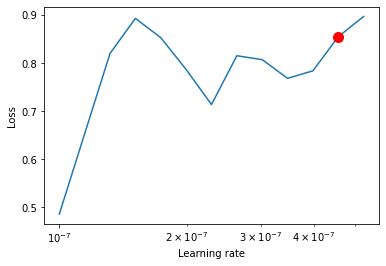

In [119]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=0.1,
    min_lr=1e-7,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [120]:
res.suggestion()

4.5708818961487505e-07

In [121]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate= res.suggestion(),
    hidden_size=16,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=1, 
    loss = new_tweedieloss(),
    log_interval=10,  
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 39.8k


In [122]:
#Early Stopping 
MIN_DELTA  = 1e-7
PATIENCE   = 30

#PL Trainer
MAX_EPOCHS = 2000

GPUS = 1



# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=MIN_DELTA, patience=PATIENCE, verbose=False, mode="min")
lr_logger = LearningRateMonitor(logging_interval='epoch')  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard



checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='../../results/models/tft/',
    filename='MODEL_tft-tweedie-loss-epoch_{epoch:02d}-val_loss_{val_loss:.3f}',
    auto_insert_metric_name=False,
    
 )

trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    gpus=GPUS,
    #weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,#oment in for training, running valiation every 30 batches
    #fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback,checkpoint_callback],
    #log_every_n_steps=10,
    logger=logger,
)
trainer.enforce_positive_output=True


print('holas')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


holas


In [123]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | new_tweedieloss                 | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 13.5 K
3  | prescalers                         | ModuleDict                      | 192   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.3 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Sanity Checking DataLoader 0:   0%|                                                                                 | 0/2 [00:00<?, ?it/s]wtahsd!!
wtahsd!!
Epoch 0:  45%|█████████████████████▉                           | 30/67 [00:05<00:06,  5.64it/s, loss=2.23, v_num=1, train_loss_step=2.020]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                                     | 0/37 [00:00<?, ?it/s]wtahsd!!
wtahsd!!

Epoch 0:  60%|█████████████████████████████▎                   | 40/67 [00:10<00:06,  3.90it/s, loss=2.23, v_num=1, train_loss_step=2.020]wtahsd!!
wtahsd!!

Epoch 0:  90%|███████████████████████████████████████████▉     | 60/67 [00:17<00:01,  3.52it/s, loss=2.23, v_num=1, train_loss_step=2.020]wtahsd!!
wtahsd!!

Epoch 1:  45%|████     | 30/67 [00:05<00:06,  5.49it/s, loss=1.87, v_num=1, train_loss_step=1.090, val_loss=3.170, train_loss_epoch=2.610]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|   

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



wtahsd!!
wtahsd!!

Epoch 229:  60%|████▏  | 40/67 [00:11<00:07,  3.58it/s, loss=1.55, v_num=1, train_loss_step=2.540, val_loss=2.840, train_loss_epoch=1.930]wtahsd!!
wtahsd!!

Epoch 229:  90%|██████▎| 60/67 [00:18<00:02,  3.30it/s, loss=1.55, v_num=1, train_loss_step=2.540, val_loss=2.840, train_loss_epoch=1.930]wtahsd!!
wtahsd!!

Epoch 233:  90%|███████▏| 60/67 [00:17<00:02,  3.36it/s, loss=2.1, v_num=1, train_loss_step=1.980, val_loss=2.830, train_loss_epoch=2.310]wtahsd!!
wtahsd!!

Epoch 234:  45%|███▏   | 30/67 [00:05<00:07,  5.04it/s, loss=1.83, v_num=1, train_loss_step=2.870, val_loss=2.830, train_loss_epoch=1.980]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                                     | 0/37 [00:00<?, ?it/s]wtahsd!!
wtahsd!!

Epoch 234:  60%|████▏  | 40/67 [00:11<00:07,  3.63it/s, loss=1.83, v_num=1, train_loss_step=2.870, val_loss=2.830, train_loss_epoch=1.980]wtahsd!!
wtahsd!!

Epoch 234:  90%|██████▎| 6

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




Epoch 269:  90%|██████▎| 60/67 [00:18<00:02,  3.32it/s, loss=1.93, v_num=1, train_loss_step=1.230, val_loss=2.780, train_loss_epoch=1.640]wtahsd!!
wtahsd!!

Epoch 270:  45%|███▏   | 30/67 [00:06<00:07,  4.77it/s, loss=1.96, v_num=1, train_loss_step=2.590, val_loss=2.790, train_loss_epoch=1.790]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                                                                     | 0/37 [00:00<?, ?it/s]wtahsd!!
wtahsd!!

Epoch 270:  60%|████▏  | 40/67 [00:11<00:07,  3.49it/s, loss=1.96, v_num=1, train_loss_step=2.590, val_loss=2.790, train_loss_epoch=1.790]wtahsd!!
wtahsd!!

Epoch 270:  90%|██████▎| 60/67 [00:18<00:02,  3.26it/s, loss=1.96, v_num=1, train_loss_step=2.590, val_loss=2.790, train_loss_epoch=1.790]wtahsd!!
wtahsd!!

Epoch 271:  45%|███▏   | 30/67 [00:06<00:07,  4.94it/s, loss=2.06, v_num=1, train_loss_step=1.750, val_loss=2.780, train_loss_epoch=2.270]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%| 

In [124]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
print(best_model_path)
best_model_name = best_model_path.split('/')[-1]
print('best_model_name = ',best_model_name)

/media/cristian/Extreme SSD/Investigacion/DATATHONES/entel-2022/DATATHON-ENTEL-2022---Reto2/results/models/tft/MODEL_tft-tweedie-loss-epoch_355-val_loss_2.679.ckpt
best_model_name =  MODEL_tft-tweedie-loss-epoch_355-val_loss_2.679.ckpt


In [125]:
# calcualte root mean squared error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
val_predictions = best_tft.predict(val_dataloader)
criterion = nn.MSELoss()
rmse_val = torch.sqrt(criterion(actuals,val_predictions)).item()
print('rmse_val = ',rmse_val)
#rmse_val =  4.774808883666992

rmse_val =  0.014048364944756031


<AxesSubplot:xlabel='ratio'>

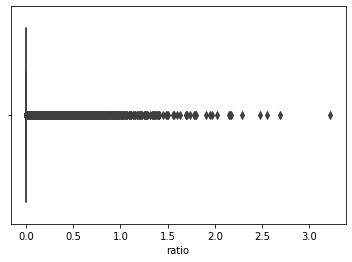

In [126]:
import seaborn as sns
sns.boxplot(data=df_train,x='ratio')

In [127]:
print('max_prediction_length:',max_prediction_length)
print('max_encoder_length   :',max_encoder_length)

max_prediction_length: 10
max_encoder_length   : 40


In [128]:
# select last 30 days from data (max_encoder_length is 24)
encoder_data = df_train[lambda x: x.date_block_num > x.date_block_num.max() - max_encoder_length]

print(encoder_data['date_block_num'].min(),encoder_data['date_block_num'].max())
#print(encoder_data['DATE'].min(),encoder_data['DATE'].max())
encoder_data

10 49


,Z_MODELO,Z_PUNTO_VENTA,Z_GAMA,ratio,date_block_num,days_from_payday,log_ratio,mean_sales_by_Z_MODELO,mean_sales_by_Z_PUNTO_VENTA,mean_sales_by_Z_GAMA,mean_sales_by_Z_MODELO_Z_GAMA,mean_sales_by_Z_PUNTO_VENTA_Z_GAMA,dayofweek,month,dayofyear
10,MOD_1,PVENT_1,GAM_1,0.000000,10,5,-18.421875,0.000000,0.029221,0.002880,0.000000,0.034363,0,7,207
11,MOD_1,PVENT_1,GAM_1,0.000000,11,13,-18.421875,0.000000,0.024139,0.002939,0.000000,0.037018,0,8,214
12,MOD_1,PVENT_1,GAM_1,0.000000,12,6,-18.421875,0.000000,0.026718,0.003031,0.000000,0.043304,0,8,221
13,MOD_1,PVENT_1,GAM_1,0.000000,13,15,-18.421875,0.000000,0.028458,0.002882,0.000000,0.039307,0,8,228
14,MOD_1,PVENT_1,GAM_1,0.000000,14,8,-18.421875,0.000000,0.029739,0.002974,0.000000,0.045258,0,8,235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2358645,MOD_99,PVENT_99,GAM_3,0.000000,45,3,-18.421875,0.007484,0.000578,0.002441,0.007484,0.000000,0,3,87
2358646,MOD_99,PVENT_99,GAM_3,0.000000,46,11,-18.421875,0.007896,0.000306,0.002632,0.007896,0.000509,0,4,94
2358647,MOD_99,PVENT_99,GAM_3,0.005993,47,4,-5.117188,0.006664,0.000737,0.002316,0.006664,0.000545,0,4,101
2358648,MOD_99,PVENT_99,GAM_3,0.003273,48,12,-5.722656,0.010201,0.000510,0.002502,0.010201,0.000744,0,4,108


In [129]:

last_data = df_train[df_train['date_block_num'].isin([idx  -  max_prediction_length for idx in df_test['date_block_num'].unique()])]
last_data['date_block_num'] = last_data['date_block_num'] + max_prediction_length

decoder_data = pd.merge(df_test[[col for col in df_test.columns if 'ratio' not in col]], 
        last_data[['date_block_num','Z_MODELO','Z_PUNTO_VENTA','Z_GAMA',"ratio"]+statistics_columns],
        on = ['date_block_num', 'Z_MODELO','Z_PUNTO_VENTA','Z_GAMA',],
                        how='left'
        )


encoder_data.replace([np.inf, -np.inf, np.nan],0,inplace=True)
decoder_data.replace([np.inf, -np.inf, np.nan],0,inplace=True)


# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [130]:
last_data[['date_block_num','Z_MODELO','Z_PUNTO_VENTA','Z_GAMA',"ratio"]+statistics_columns]

,date_block_num,Z_MODELO,Z_PUNTO_VENTA,Z_GAMA,ratio,log_ratio,mean_sales_by_Z_MODELO,mean_sales_by_Z_PUNTO_VENTA,mean_sales_by_Z_GAMA,mean_sales_by_Z_MODELO_Z_GAMA,mean_sales_by_Z_PUNTO_VENTA_Z_GAMA
40,50,MOD_1,PVENT_1,GAM_1,0.361084,-1.018555,0.010727,0.033447,0.002653,0.010727,0.048187
41,51,MOD_1,PVENT_1,GAM_1,0.548340,-0.600586,0.015358,0.030426,0.002720,0.015358,0.047791
42,52,MOD_1,PVENT_1,GAM_1,0.884277,-0.122864,0.018402,0.036530,0.002678,0.018402,0.054840
43,53,MOD_1,PVENT_1,GAM_1,1.017578,0.017349,0.021439,0.029984,0.002529,0.021439,0.040741
44,54,MOD_1,PVENT_1,GAM_1,1.449219,0.371094,0.029770,0.035919,0.002375,0.029770,0.046478
...,...,...,...,...,...,...,...,...,...,...,...
2358645,55,MOD_99,PVENT_99,GAM_3,0.000000,-18.421875,0.007484,0.000578,0.002441,0.007484,0.000000
2358646,56,MOD_99,PVENT_99,GAM_3,0.000000,-18.421875,0.007896,0.000306,0.002632,0.007896,0.000509
2358647,57,MOD_99,PVENT_99,GAM_3,0.005993,-5.117188,0.006664,0.000737,0.002316,0.006664,0.000545
2358648,58,MOD_99,PVENT_99,GAM_3,0.003273,-5.722656,0.010201,0.000510,0.002502,0.010201,0.000744


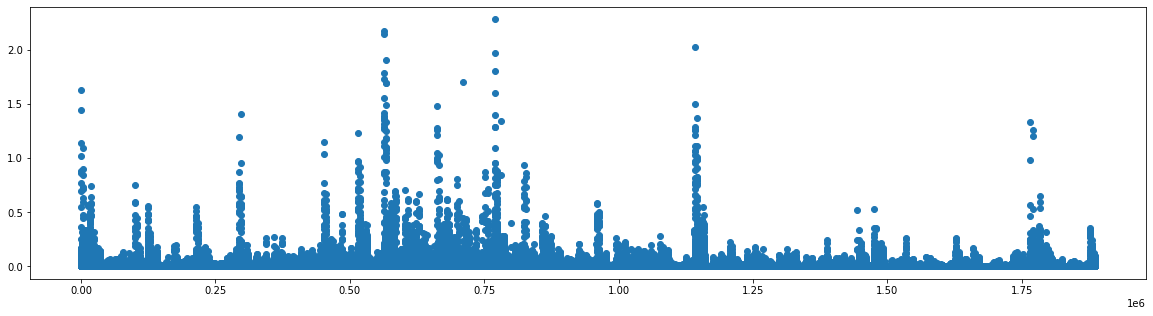

In [96]:
import matplotlib.pyplot as plt

aux = encoder_data['ratio'].values

fig = plt.figure(figsize=(20,5))
plt.plot(aux,'o')
plt.show()

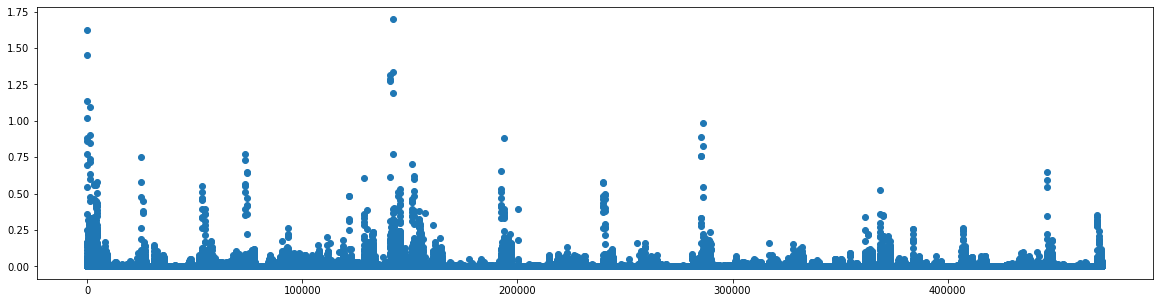

In [95]:
import matplotlib.pyplot as plt

aux = decoder_data['ratio'].values

fig = plt.figure(figsize=(20,5))
plt.plot(aux,'o')
plt.show()

In [97]:
new_raw_predictions = best_tft.predict(new_prediction_data, mode="prediction", return_x=False)

In [98]:
predictions = pd.DataFrame(new_raw_predictions.numpy()).T
predictions['date_block_num'] = sorted(df_test['date_block_num'].unique())
predictions = pd.melt(predictions, id_vars=['date_block_num'])
predictions = predictions.sort_values(['date_block_num', 'variable']).reset_index(drop=True)
df_test[['date_block_num','Z_MODELO','Z_PUNTO_VENTA','Z_GAMA']].sort_values(['date_block_num', 'Z_MODELO','Z_PUNTO_VENTA','Z_GAMA']).reset_index(drop=True)
df_test2 = df_test.join(predictions['value'])

In [99]:
df_test2.head()

,date_block_num,Z_MODELO,Z_PUNTO_VENTA,Z_GAMA,ratio,dayofweek,month,dayofyear,days_from_payday,value
0,50,MOD_1,PVENT_1,GAM_1,0.0,0,5,122,13,0.344408
1,51,MOD_1,PVENT_1,GAM_1,0.0,0,5,129,6,0.060787
2,52,MOD_1,PVENT_1,GAM_1,0.0,0,5,136,15,0.003178
3,53,MOD_1,PVENT_1,GAM_1,0.0,0,5,143,8,-0.000798
4,54,MOD_1,PVENT_1,GAM_1,0.0,0,5,150,1,0.004788


In [100]:
import pickle

reverse_mapping_file = '../../utils/reverse_dict_mapping_list.txt'

with open(reverse_mapping_file, 'rb') as f:
    reverse_mapping = pickle.load( f)

In [ ]:
#reverse_mapping#

In [101]:
#descriptive_columns = ['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA']
descriptive_columns = ['Z_MARCA', 'Z_GAMA', 'Z_MODELO',
                       'Z_DEPARTAMENTO', 'Z_PUNTO_VENTA']
i=0
for column in descriptive_columns:
    if column in df_test2.columns:
        df_test2[column] = df_test2[column].map(reverse_mapping[i])
    i+=1

In [102]:
df_test2.head()

,date_block_num,Z_MODELO,Z_PUNTO_VENTA,Z_GAMA,ratio,dayofweek,month,dayofyear,days_from_payday,value
0,50,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,0.0,0,5,122,13,0.344408
1,51,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,0.0,0,5,129,6,0.060787
2,52,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,0.0,0,5,136,15,0.003178
3,53,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,0.0,0,5,143,8,-0.000798
4,54,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,0.0,0,5,150,1,0.004788


In [103]:

inv_dict_dates = {v: k for k, v in dict_dates.items()}
df_test2['Z_WEEK'] = df_test2['date_block_num'].map(inv_dict_dates)

In [104]:
for column in ['Z_MODELO','Z_PUNTO_VENTA','Z_GAMA','Z_WEEK']:
    df_test2[column] = df_test2[column].astype(str)

In [105]:
df_test2['ID'] = df_test2['Z_MODELO'] + '|' + df_test2['Z_PUNTO_VENTA'] + '|' + df_test2['Z_GAMA'] + '|' + df_test2['Z_WEEK']

In [106]:
df_test2['ratio'] = np.maximum(df_test2['value'],0)
submission = df_test2[['Z_WEEK','ID','ratio']]#.groupby('ID').sum().reset_index()

In [107]:
df_test2.head(10)

,date_block_num,Z_MODELO,Z_PUNTO_VENTA,Z_GAMA,ratio,dayofweek,month,dayofyear,days_from_payday,value,Z_WEEK,ID
0,50,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,0.344408,0,5,122,13,0.344408,SEMANA_51,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...
1,51,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,0.060787,0,5,129,6,0.060787,SEMANA_52,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...
2,52,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,0.003178,0,5,136,15,0.003178,SEMANA_53,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...
3,53,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,0.000000,0,5,143,8,-0.000798,SEMANA_54,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...
4,54,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,0.004788,0,5,150,1,0.004788,SEMANA_55,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...
5,55,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,0.000444,0,6,157,9,0.000444,SEMANA_56,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...
6,56,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,0.002987,0,6,164,2,0.002987,SEMANA_57,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...
7,57,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,0.000469,0,6,171,10,0.000469,SEMANA_58,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...
8,58,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,0.000980,0,6,178,3,0.000980,SEMANA_59,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...
9,59,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,da45328ba820604eb99694768f2a430cd933d161601dcb...,76df0c6db32d4e04e0ef6a3a6a1e1686677e34308d9435...,0.000627,0,7,185,11,0.000627,SEMANA_60,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...


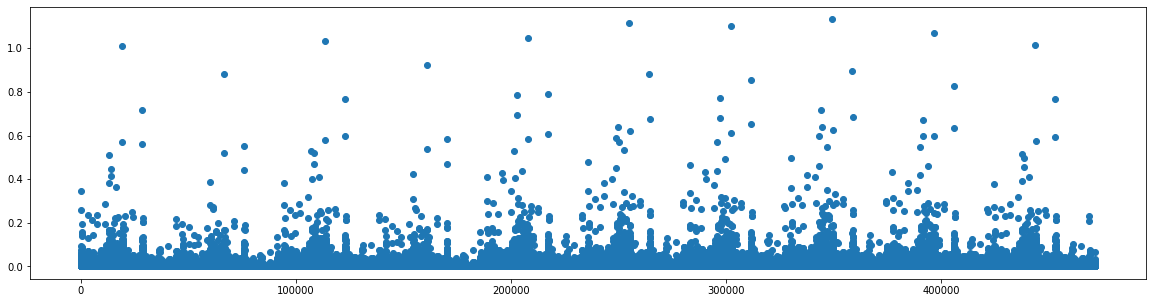

In [111]:
import matplotlib.pyplot as plt

aux = df_test2['ratio'].values

fig = plt.figure(figsize=(20,5))
plt.plot(aux,'o')
plt.show()

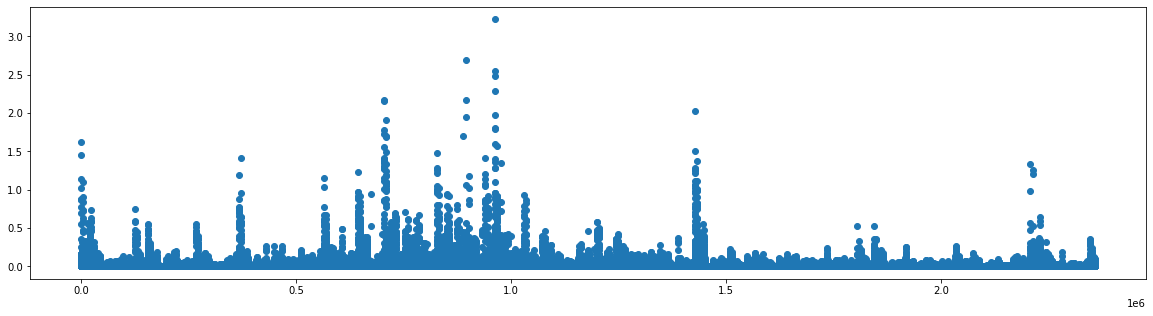

In [114]:
import matplotlib.pyplot as plt

aux = df_train['ratio'].values

fig = plt.figure(figsize=(20,5))
plt.plot(aux,'o')
plt.show()

In [115]:
#submission['Demanda'] = 0.9#submission['value']
import numpy as np
# +'_refencia_best_pred_rmse_'+str(np.round(rms,2))+
submission[['ID', 'ratio']].to_csv('../../results/models/tft/'+best_model_name+'_MAX_EPOCHS_'+str(MAX_EPOCHS)+'_val_'+str(np.round(rmse_val,2))+'_RATIOS.csv', index = False, sep = ',')

In [116]:
submission.head(1)

,Z_WEEK,ID,ratio
0,SEMANA_51,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,0.344408


In [117]:
submission.head(1)

,Z_WEEK,ID,ratio
0,SEMANA_51,b48f98af5dc143cab1e64b72394fc2a31c8f2f53e20101...,0.344408
